In [1]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np
import os
import time

In [2]:
dim = 2

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"),  
                                         elementRes=(384,192), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(28e5,9e5)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [4]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
#Boundary conditions

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
BWalls = linearMesh.specialSets["MinJ_VertexSet"]



#free sides, no slip top
mixedslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                                                  nodeIndexSets=(IWalls+BWalls, JWalls)  )

In [6]:
#uw.conditions.DirichletCondition?

In [7]:
#uw.shapes.BelowCosinePlane?

##Geometry

In [8]:
def below_cosine_func(x,y):
    if y < 7e3*math.cos(2*math.pi*(x/28e5)) + 7e5:
        return True
    else:
        return False

In [9]:
#cosineShape = uw.shapes.BelowCosinePlane(dim, amplitude=7e3, wavelength=28e5, offset=7e5)
maxCoord=(28e5,9e5)
below_cosine_func(maxCoord[0]/2., maxCoord[1]/2.)

True

##Particles

In [10]:
# We create swarms of particles which can advect, and which may determine 'materials'
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# Now we add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="char", count=1 )

# Layouts are used to populate the swarm across the whole domain
# Create the layout object
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=36 )
# Now use it to populate.
gSwarm.populate_using_layout(layout=layout )

# initialise the 'materialVariable' data to represent two different materials. 

mantleIndex = 1
lithosphereIndex = 2
airIndex = 3


# Set the material to air everywhere via the numpy array
materialVariable.data[:] = airIndex

In [11]:
for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    x = gSwarm.particleCoordinates.data[particleID][0]
    y = gSwarm.particleCoordinates.data[particleID][1]
    if below_cosine_func(x,y):
        if gSwarm.particleCoordinates.data[particleID][1] > 6e5:
            materialVariable.data[particleID] =  lithosphereIndex
        else:
            materialVariable.data[particleID] =  mantleIndex

for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    if cosineShape.pointInShape(tuple(gSwarm.particleCoordinates.data[particleID])):
        if gSwarm.particleCoordinates.data[particleID][1] > 6e5:
            materialVariable.data[particleID] =  lithosphereIndex
        else:
            materialVariable.data[particleID] =  mantleIndex

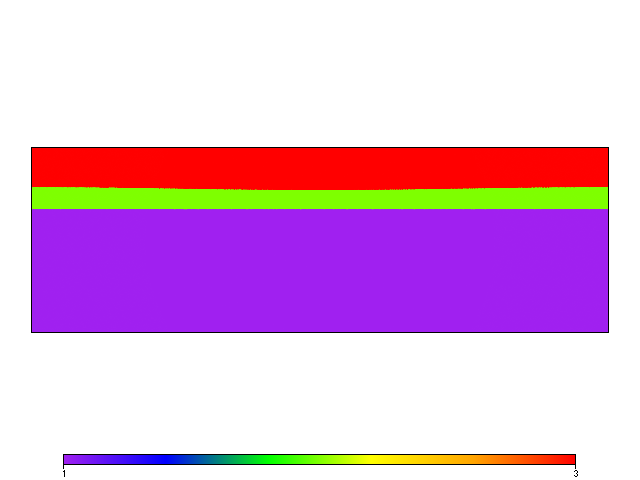

In [12]:
fig1 = plt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable )
#fig1.save_database('test_pol.gldb')
fig1.show()

In [13]:
incr = 5000.
xps = np.linspace(0 + 1000.,28e5 - 1000., 10000)
yps = [7e5 + 7e3*np.cos(2*np.pi*(i/28e5)) for i in xps]

surfswarm = uw.swarm.Swarm( feMesh=elementMesh )
surfswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32)

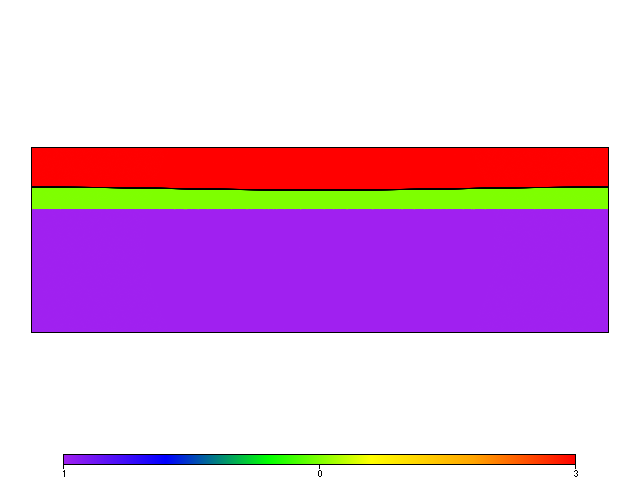

In [14]:
fig2 = plt.Figure()
fig2.Points( swarm=surfswarm, pointSize=2.0)
fig2.Points( swarm=gSwarm, colourVariable=materialVariable )
fig2.save_database('test_pol.gldb')
#fig1.save_database('test_pol.gldb')
fig2.show()

##Material properties

In [15]:
print(1e23, 10.**23)

(1e+23, 1e+23)


In [16]:
#
viscosityMapFn  = fn.branching.map( keyFunc = materialVariable, 
                         mappingDict = {mantleIndex:1e21,airIndex:1e18,lithosphereIndex:1e23} )


densityMapFn = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = {mantleIndex:3300.,airIndex:0., lithosphereIndex:3300.} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
if dim ==2:
    gravity = ( 0.0, -10.0 )
else:
    gravity = ( 0.0, -10.0, 0.0)
    

# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading

buoyancyFn = gravity*densityMapFn

In [17]:
# Setup the Stokes system again, now with full viscosity
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[mixedslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityMapFn), 
                              bodyForceFn=buoyancyFn)

In [18]:
solver = uw.systems.Solver(stokesPIC)

In [19]:
solver.solve()

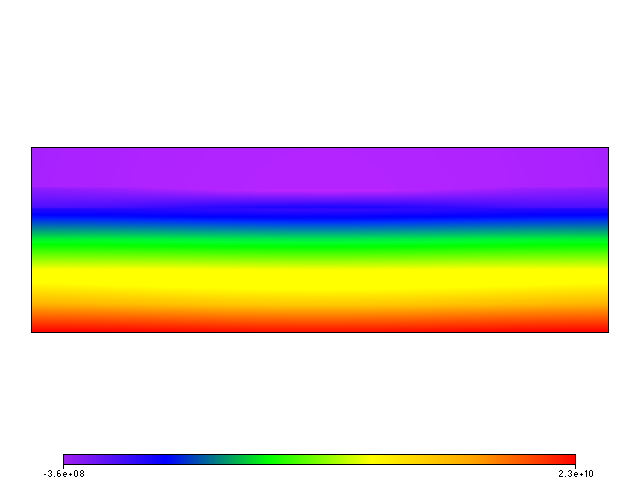

In [20]:
fig3 = plt.Figure()
fig3.Surface(pressureField, linearMesh)
fig3.show()

In [21]:
# Create advector objects to advect the swarms. We specify second order integration.
advector1 = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector( swarm=surfswarm, velocityField=velocityField, order=2)

In [22]:
# Stepping. Initialise time and timestep.
realtime = 0.
step = 0

timevals = []
vrmsvals = []

In [23]:
def rms():
    squared = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
    area = uw.utils.Integral(1.,linearMesh)
    return math.sqrt(squared.integrate()[0]/area.integrate()[0])

def avg_temp():
    temp = uw.utils.Integral(temperatureField, linearMesh)
    return temp.integrate()[0]

def maxtop():
    test = surfswarm.particleCoordinates.data
    return np.flipud(test[test[:,1].argsort()])[0:100,1].mean()
    

In [24]:
sectoka = (3600*24*365*1000)

In [25]:
# create integral to get diff 
maxheight = []

start = time.clock()
while step<20:
    #stokesPIC2.solve(nonLinearIterate=True)
    solver.solve()
    dt1 = advector1.get_max_dt()
    dt = min((4.*sectoka),dt1)
    if step == 0:
        dt = 0.
    # Advect swarm using this timestep size
    advector1.integrate(dt)
    advector2.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    Rms = rms()
    MaxT = maxtop()
    maxheight.append(MaxT)
    #f_o.write((2*'%-15s ' + '\n') % (realtime,Rms))
    if step % 1 == 0:
        print 'step =',step, 'rms', Rms, 'max height', MaxT, 'time', realtime/sectoka

step = 1 rms 1.52555956134e-08 max height 706998.625027 time 0.0
step = 2 rms 1.52555956134e-08 max height 706300.936975 time 1.53048048086
step = 3 rms 1.37590683142e-08 max height 705617.456212 time 3.22643436022
step = 4 rms 1.2506088453e-08 max height 704915.565588 time 5.09104140304
step = 5 rms 1.08200380373e-08 max height 704193.823218 time 7.23690311119
step = 6 rms 9.35036593988e-09 max height 703487.98471 time 9.72937054293
step = 7 rms 8.04574784204e-09 max height 702823.236628 time 12.6145179037
step = 8 rms 6.35058736339e-09 max height 702123.010508 time 16.2639284291
step = 9 rms 3.91279823986e-09 max height 701668.359347 time 20.2639284291
step = 10 rms 3.22701477982e-09 max height 701364.921939 time 24.2639284291
step = 11 rms 2.77190760913e-09 max height 701105.98489 time 28.2639284291
step = 12 rms 1.8712789339e-09 max height 700903.515111 time 32.2639284291
step = 13 rms 1.2409463972e-09 max height 700750.369948 time 36.2639284291
step = 14 rms 7.25054678546e-10 max 

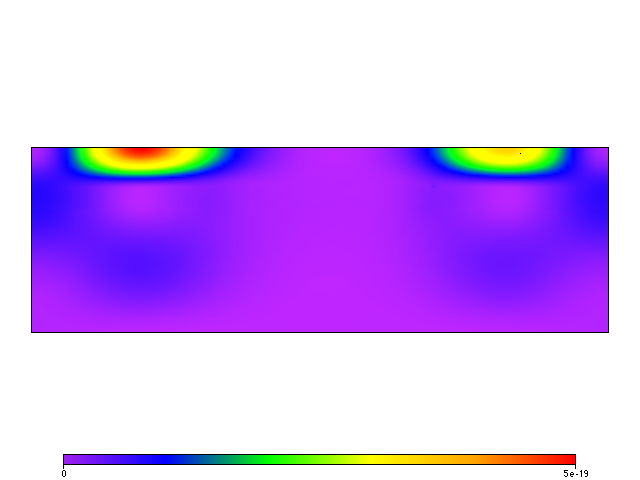

In [26]:
# lets check FEM solution
velMag = plt.Figure()
velMag.Surface(fn.math.dot(velocityField,velocityField), linearMesh)
velMag.VectorArrows(velocityField, linearMesh,arrowHeadSize=0.1, lengthScale=5e13)
velMag.show()

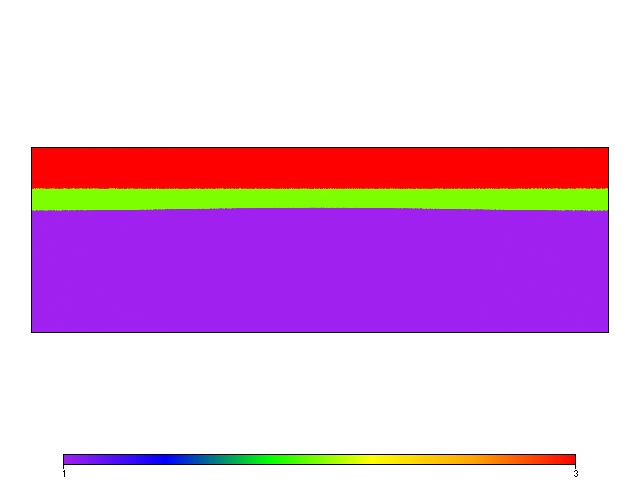

In [27]:
fig1 = plt.Figure()
fig1.Points( swarm=gSwarm, colourVariable=materialVariable )
fig1.VectorArrows(velocityField, linearMesh,lengthScale=1e12)
fig1.show()

In [28]:
import matplotlib.pylab as pyplt

In [ ]:
kms = [j/1000. - 700 for j in maxheight]

In [31]:
kyas = [i/sectoka for i in timevals]

In [32]:
#Analytic solution
y = -0.2139e-11
def analytic_height(y,t):
    return 7e3*math.exp(y*t)

In [33]:
ah = [analytic_height(y,i)/1000. for i in timevals]

In [34]:
uw_paper = np.loadtxt("./CASE1_data/UNDERWORLD_sa_100_18.dat")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


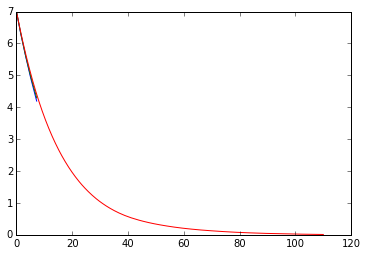

In [35]:
%pylab inline
pyplt.plot(kyas, kms)
pyplt.plot(kyas, ah)
pyplt.plot(uw_paper[:,0], uw_paper[:,1])